### Implementing *Extrapolating Quantum Observables with Machine Learning: Inferring Multiple Phase Transitions from Properties of a Single Phase*

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt

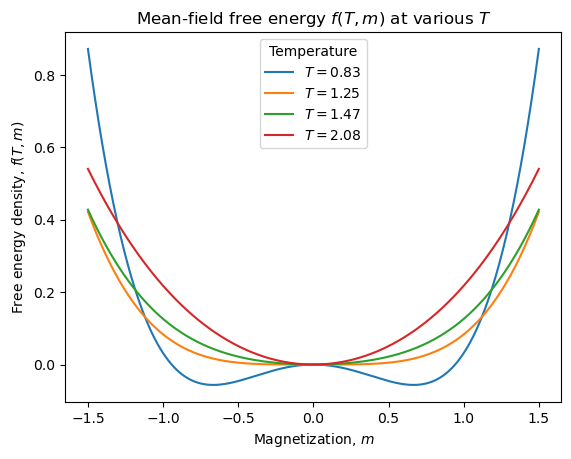

In [5]:
# define free energy density f(T, m) with critical temperature T_c = 1.25
def f(T, m, T_c = 1.25):
    return 0.5 * (1 - T_c / T) * m**2 + (T_c / T)**3 * m**4 / 12

# magnetization range
m = np.linspace(-1.5, 1.5, 500)

# Temperatures to plot
Ts = [0.83, 1.25, 1.47, 2.08]

plt.figure()
for T in Ts:
    plt.plot(m, f(T, m), label = f'$T = {T:.2f}$')
plt.xlabel('Magnetization, $m$')
plt.ylabel('Free energy density, $f(T, m)$')
plt.title('Mean-field free energy $f(T, m)$ at various $T$')
plt.legend(title='Temperature')
plt.show()

In [6]:
# more imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ConstantKernel
from sklearn.preprocessing import StandardScaler
import itertools

In [7]:
# Setting up for iterative kernel search

# compute BIC, or Bayesion Information Criterion for a fitted GP
def compute_bic(gp: GaussianProcessRegressor, X: np.ndarray, y: np.ndarray) -> float:
    n = X.shape[0]
    log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    kernel_params = gp.kernel_.theta.shape[0]
    bic = log_likelihood - 0.5 * kernel_params * np.log(n)
    return bic

# Base kernels
base_kernels = {
    'LIN': ConstantKernel(1.0) * DotProduct(),
    'RBF': ConstantKernel(1.0) * RBF(length_scale = 1.0),
    'MAT': ConstantKernel(1.0) * Matern(length_scale = 1.0, nu = 2.5),
    'RQ': ConstantKernel(1.0) * RationalQuadratic(length_scale = 1.0, alpha = 1.0)
}

In [8]:
# implement iterative kernel search to find the optimal kernel combination
def iterative_kernel_search(X: np.ndarray, y: np.ndarray, max_iter: int=10):
    bic_scores = {}
    for name, kernel in base_kernels.items():
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y = True)
        gp.fit(X, y)
        bic_scores[name] = compute_bic(gp, X, y)
    best_name = max(bic_scores, key = bic_scores.get)
    best_kernel = base_kernels[best_name]
    best_bic = bic_scores[best_name]
    history = [(best_name, best_bic)]
    
    for _ in range(max_iter):
        candidates = {}
        for name, kernel in base_kernels.items():
            if name == best_name:
                continue
            for op, combo_k in [('+', best_kernel + kernel), ('*', best_kernel * kernel)]:
                combo_name = f"{best_name}{op}{name}"
                gp = GaussianProcessRegressor(kernel = combo_k, normalize_y = True)
                gp.fit(X, y)
                bic_val = compute_bic(gp, X, y)
                candidates[combo_name] = (bic_val, combo_k)
        combo_name, (combo_bic, combo_k) = max(candidates.items(), key= lambda item: item[1][0])
        if combo_bic > best_bic:
            best_name = combo_name
            best_kernel = combo_k
            best_bic = combo_bic
            history.append((best_name, best_bic))
        else:
            break
    return best_kernel, history

In [9]:
# number of samples
N = 330

# the figure uses 330 random points uniformly from {1.47 < T < 2.08} x {-1.25 < m < 1.25}
T_train = np.random.uniform(low=1.47, high=2.08, size=N)
m_train = np.random.uniform(low=-1.25, high=1.25, size=N)

# compute training outputs
y_train = f(T_train, m_train)
X_train = np.vstack([T_train, m_train]).T
scaler = StandardScaler().fit(X_train)     
X_train_scaled = scaler.transform(X_train)

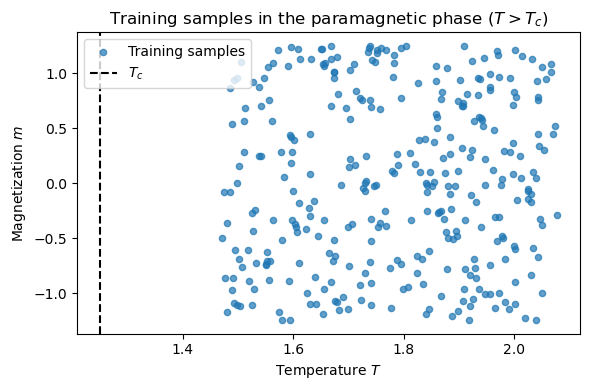

In [10]:
# visualize the training region
plt.figure(figsize=(6, 4))
plt.scatter(T_train, m_train, s=20, alpha=0.7, label='Training samples')
plt.axvline(1.25, color='k', linestyle='--', label='$T_c$')
plt.xlabel('Temperature $T$')
plt.ylabel('Magnetization $m$')
plt.title('Training samples in the paramagnetic phase ($T > T_c$)')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
best_kernel, history = iterative_kernel_search(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

In [12]:
gp_final = GaussianProcessRegressor(kernel=best_kernel, normalize_y=True)
gp_final.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1), normalize_y=True)

In [13]:
def m0_exact(T, Tc=1.25):
    val = -3 * (1 - Tc / T) / ((Tc / T)**3)
    return np.sqrt(np.clip(val, 0, None))

def extract_order_parameter(model, T_vals, m_vals):
    m0 = []
    for T in T_vals:
        # build test points for this temperature
        X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
        f_pred = model.predict(X_test)
        # pick the m that minimizes predicted free energy
        idx = np.argmin(f_pred)
        m0.append(abs(m_vals[idx]))
    return np.array(m0)

def extracted_vs_analytic_order_parameter(model, model_name):
    # Extract order parameter m0(T) by grid search
    T_vals = np.linspace(1.5, 0.8, 100)
    m_vals = np.linspace(-1.25, 1.25, 400)
    m0_pred = extract_order_parameter(model, T_vals, m_vals)

    # Analytic solution for comparison
    m0_analytic = m0_exact(T_vals)

    # Plot inset figure
    plt.figure()
    plt.plot(T_vals, m0_analytic, label=f'{model_name} predicted $m_0(T)$')
    plt.plot(T_vals, m0_pred, '--', label='Analytic $m_0(T)$')
    plt.legend(loc = 'best')
    plt.xlabel('Temperature $T$')
    plt.ylabel('Order parameter $m_0(T)$')
    plt.title('Inset Figure: Order Parameter vs. Temperature')
    plt.tight_layout()
    plt.gca().invert_xaxis()
    plt.show()

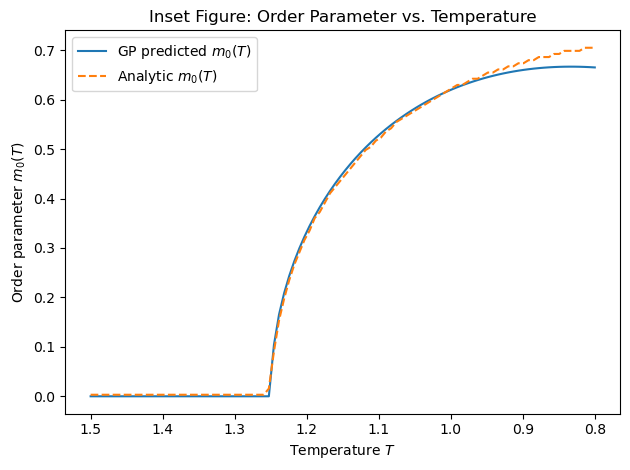

In [14]:
extracted_vs_analytic_order_parameter(gp_final, "GP")

In [15]:
def graph_extrapolated_free_energy(model, model_name, T):
    m_vals = np.linspace(-1.5, 1.5, 500)

    X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
    f_pred = model.predict(X_test)
    f_true = f(T, m_vals)
    plt.plot(m_vals, f_true, label=f'Exact $f(T, m)$, $T = {T:.2f}$')
    plt.plot(m_vals, f_pred, '--', label=f'GP $\\hat f(T, m)$, $T = {T:.2f}$')

    plt.xlabel('Magnetization $m$')
    plt.ylabel('Free energy $f$')
    plt.title(f'{model_name} Extrapolated vs Exact Free Energy\nas Temperature is Lowered Across $T_c$')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

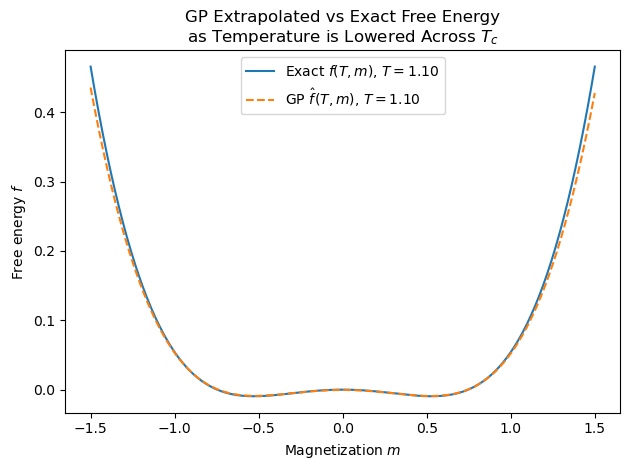

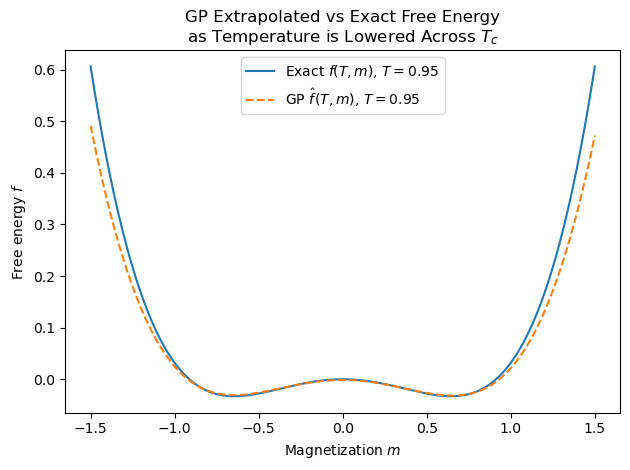

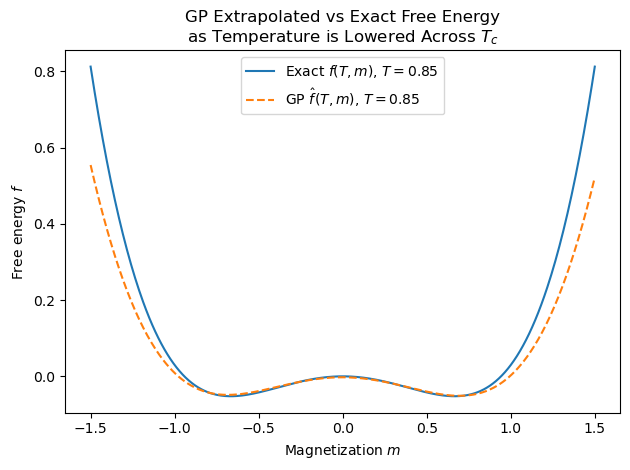

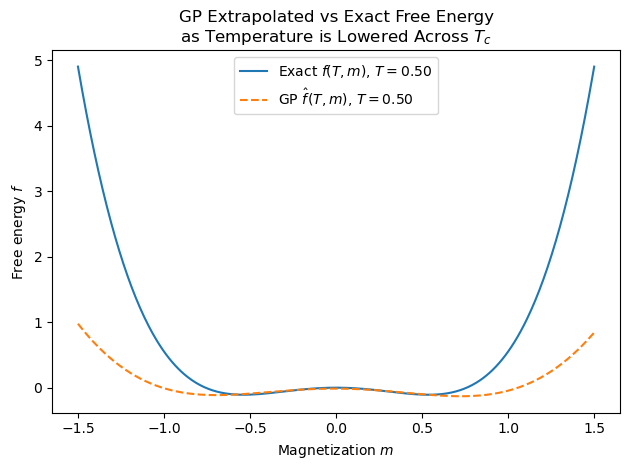

In [16]:
# Plotting the extrapolated mean free-energy as T is lowered. 
graph_extrapolated_free_energy(gp_final, "GP", T=1.1)
graph_extrapolated_free_energy(gp_final, "GP", T=0.95)
graph_extrapolated_free_energy(gp_final, "GP", T=0.85)
graph_extrapolated_free_energy(gp_final, "GP", T=0.5)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [18]:
def evaluate_poly_regression(N, degree):
    # fix the rng for reproducibility
    np.random.seed(0)
    # keep the training data still within the paramagnetic phase, far away from Tc
    T_train = np.random.uniform(low=1.47, high=2.0, size=N)
    m_train = np.random.uniform(low=-1.25, high=1.25, size=N)
    y_train = f(T_train, m_train)
    X_train = np.vstack([T_train, m_train]).T
    # build a polynomial regression pipeline
    model = Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('lr', LinearRegression())])
    model.fit(X_train, y_train)
    #compute training MSE
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_pred, y_train)
    return model, mse, (X_train, y_train)

Degree=1, N=100 → Training MSE = 6.3702e-03
Degree=1, N=330 → Training MSE = 7.9967e-03
Degree=1, N=1000 → Training MSE = 7.6614e-03
Degree=1, N=5000 → Training MSE = 7.2634e-03
Degree=1, N=10000 → Training MSE = 7.3352e-03
Degree=2, N=100 → Training MSE = 1.1971e-04
Degree=2, N=330 → Training MSE = 1.5362e-04
Degree=2, N=1000 → Training MSE = 1.4096e-04
Degree=2, N=5000 → Training MSE = 1.3596e-04
Degree=2, N=10000 → Training MSE = 1.3327e-04
Degree=3, N=100 → Training MSE = 3.9179e-05
Degree=3, N=330 → Training MSE = 3.6276e-05
Degree=3, N=1000 → Training MSE = 4.1693e-05
Degree=3, N=5000 → Training MSE = 4.1574e-05
Degree=3, N=10000 → Training MSE = 4.0719e-05
Degree=4, N=100 → Training MSE = 1.8652e-06
Degree=4, N=330 → Training MSE = 2.3157e-06
Degree=4, N=1000 → Training MSE = 2.8089e-06
Degree=4, N=5000 → Training MSE = 2.7450e-06
Degree=4, N=10000 → Training MSE = 2.7430e-06


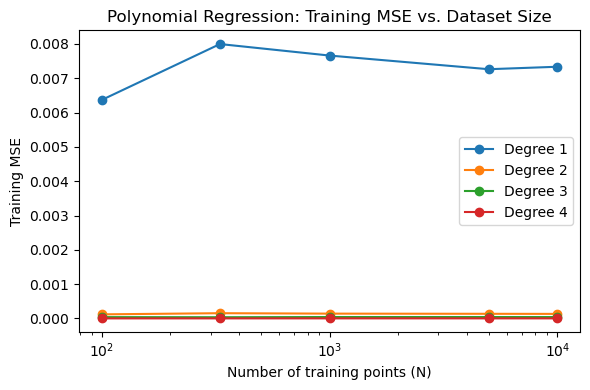

In [19]:
degrees = [1, 2, 3, 4]
N_values = [100, 330, 1000, 5000, 10000]

results = {deg: [] for deg in degrees}

for deg in degrees:
    for N in N_values:
        _, mse, (_, _)= evaluate_poly_regression(N, deg)
        results[deg].append(mse)
        print(f"Degree={deg}, N={N} → Training MSE = {mse:.4e}")

plt.figure(figsize=(6, 4))
for deg in degrees:
    plt.plot(N_values, results[deg], marker='o', label=f"Degree {deg}")
plt.xscale('log')
plt.xlabel("Number of training points (N)")
plt.ylabel("Training MSE")
plt.title("Polynomial Regression: Training MSE vs. Dataset Size")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# extrapolate mean free energy and extract order parameters for N = 10000, degree = 1, 2, 3
N = 1000
model_deg1, mse1, (X_train, y_train) = evaluate_poly_regression(N, degree = 1)
model_deg2, mse2, (_, _) = evaluate_poly_regression(N, degree = 2)
model_deg3, mse3, (_, _) = evaluate_poly_regression(N, degree = 3)
model_deg4, mse4, (_, _) = evaluate_poly_regression(N, degree = 4)

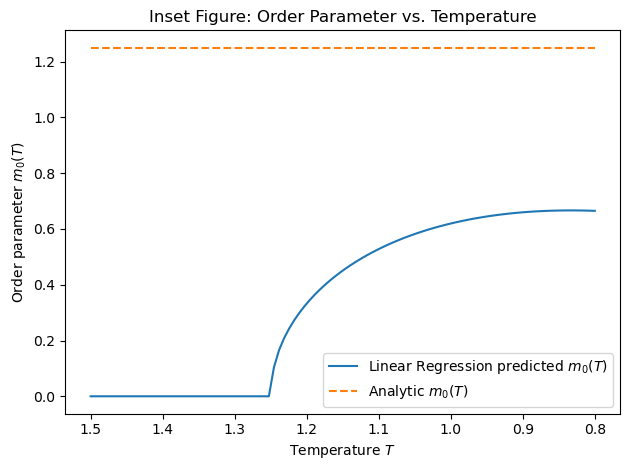

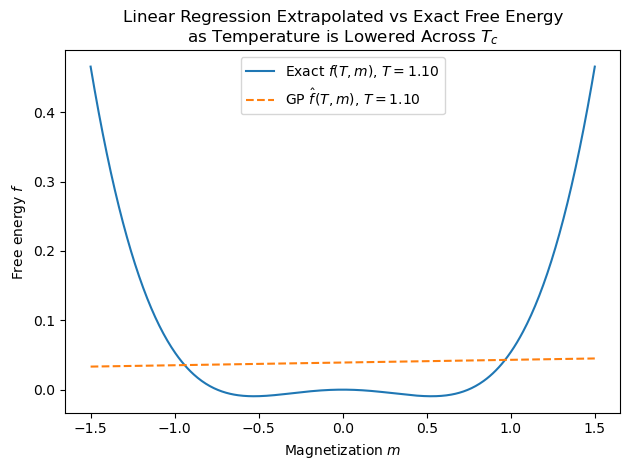

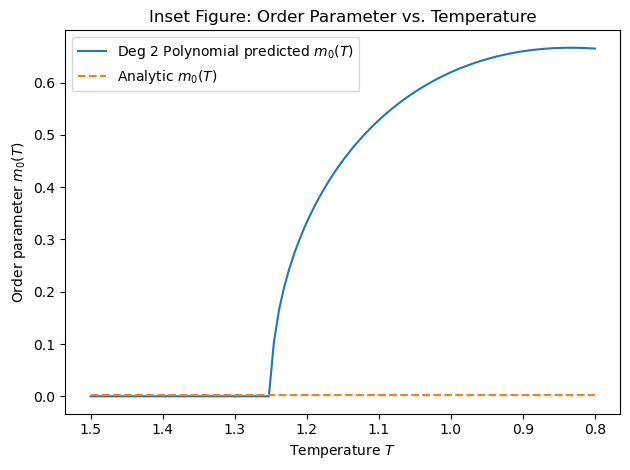

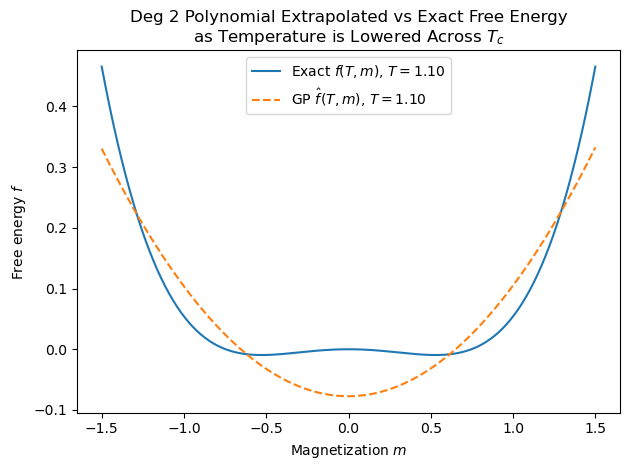

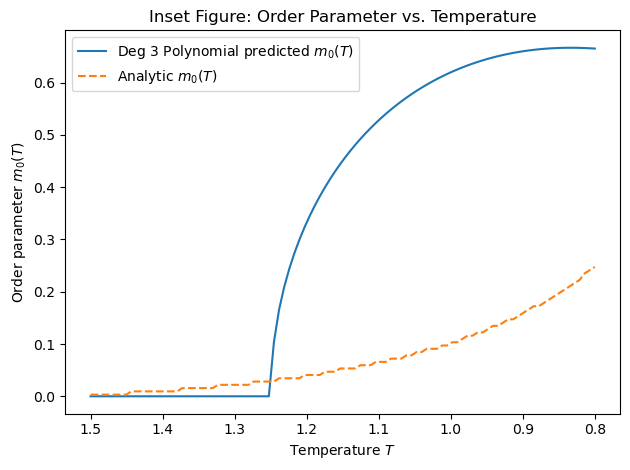

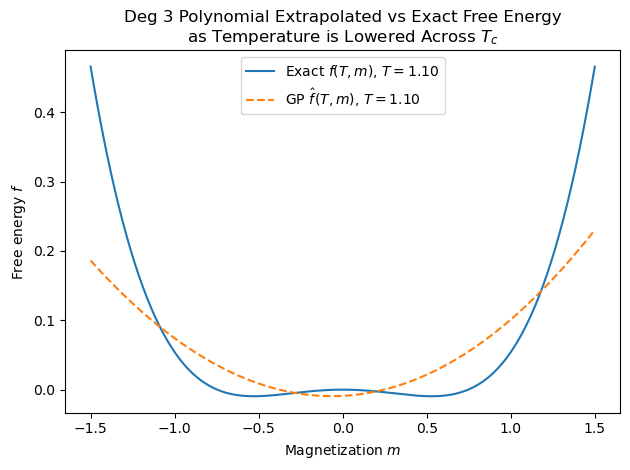

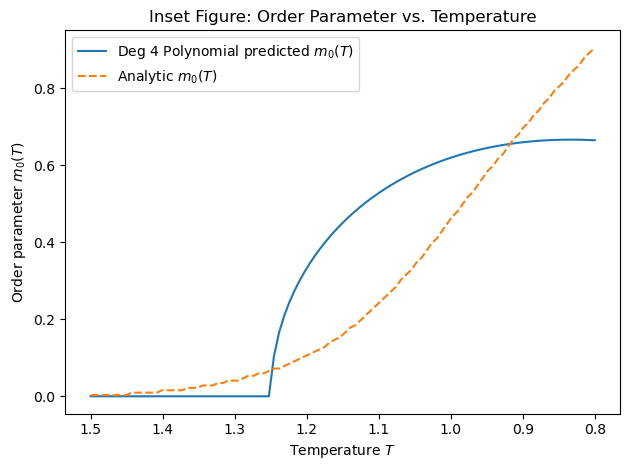

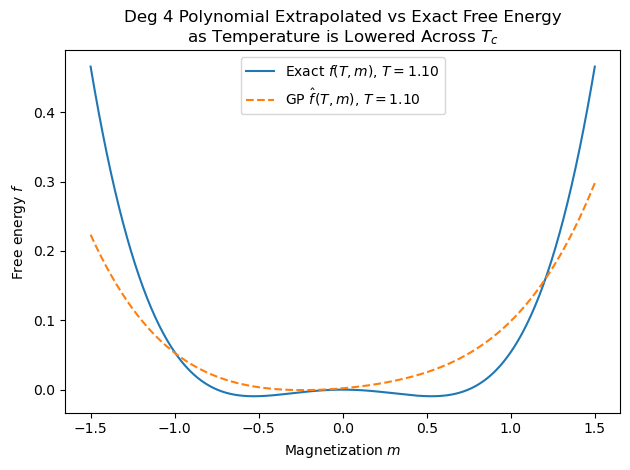

In [21]:
extracted_vs_analytic_order_parameter(model_deg1, "Linear Regression")
graph_extrapolated_free_energy(model_deg1, "Linear Regression", T=1.1)
extracted_vs_analytic_order_parameter(model_deg2, "Deg 2 Polynomial")
graph_extrapolated_free_energy(model_deg2, "Deg 2 Polynomial", T=1.1)
extracted_vs_analytic_order_parameter(model_deg3, "Deg 3 Polynomial")
graph_extrapolated_free_energy(model_deg3, "Deg 3 Polynomial", T=1.1)
extracted_vs_analytic_order_parameter(model_deg4, "Deg 4 Polynomial")
graph_extrapolated_free_energy(model_deg4, "Deg 4 Polynomial", T=1.1)

In [22]:
# model dictionary
models = {}
models[1] = model_deg1
models[2] = model_deg2
models[3] = model_deg3
models[4] = model_deg4

In [23]:
# compute each base-model's predictions on the N training points

preds = []
for deg in (1, 2, 3, 4):
    pipe = models[deg]
    preds.append(pipe.predict(X_train))
P = np.column_stack(preds)

In [49]:
alphas = [0.0, 1e-4, 1e-3, 1e-2, 1e-1]  # alpha=0 reproduces plain LinearRegression
meta_results = {}
for α in alphas:
    ridge = Ridge(alpha=α, fit_intercept=True)
    ridge.fit(P, y_train)
    w = ridge.coef_      # length‐4 array
    b = ridge.intercept_ # scalar
    y_meta_pred = ridge.predict(P)
    mse_meta    = mean_squared_error(y_train, y_meta_pred)
    meta_results[α] = (w.copy(), b, mse_meta)
    print(f"alpha={α:.1e} → meta‐train MSE={mse_meta:.3e},   weights={w.round(3)}, intercept={b:.3e}")

# Choose one α (e.g. α=1e-3) that balances nonzero lower‐degree terms & small MSE
chosen_alpha = 1e-3
w_chosen, b_chosen, _ = meta_results[chosen_alpha]
print("\n→ Using alpha =", chosen_alpha)
print("   meta‐weights w =", w_chosen.round(4), "   intercept b =", b_chosen.round(4))

alpha=0.0e+00 → meta‐train MSE=2.809e-06,   weights=[ 0.  0. -0.  1.], intercept=-1.445e-14
alpha=1.0e-04 → meta‐train MSE=2.809e-06,   weights=[0.    0.    0.003 0.997], intercept=-1.270e-14
alpha=1.0e-03 → meta‐train MSE=2.832e-06,   weights=[0.    0.    0.024 0.976], intercept=1.603e-11
alpha=1.0e-02 → meta‐train MSE=3.984e-06,   weights=[0.    0.014 0.158 0.828], intercept=9.136e-08
alpha=1.0e-01 → meta‐train MSE=1.472e-05,   weights=[0.001 0.161 0.324 0.513], intercept=6.964e-05

→ Using alpha = 0.001
   meta‐weights w = [0.000e+00 2.000e-04 2.420e-02 9.755e-01]    intercept b = 0.0


In [50]:
def f_combo(T_array, m_array, models=models, w=w_chosen, b=b_chosen):
    """
    Given T_array (shape L,) and m_array (shape L,), returns array (L,)
    of weighted combination of degree-1..4 predictions + intercept.
    """
    Xq = np.column_stack([T_array, m_array])  # shape (L,2)
    # Collect the four base predictions
    stacked = []
    for deg in (1, 2, 3, 4):
        stacked.append(models[deg].predict(Xq))
    stacked = np.column_stack(stacked)  # shape (L,4)
    return stacked.dot(w) + b  # shape (L,)

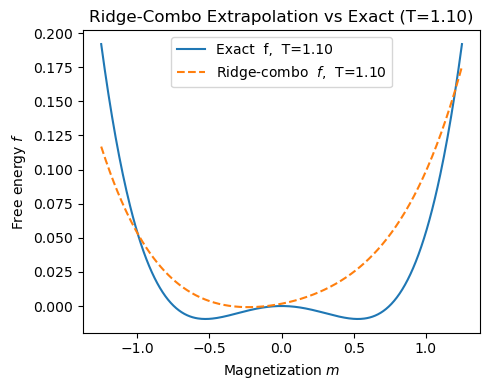

In [51]:
T_test = 1.10
m_grid = np.linspace(-1.25, 1.25, 400)
T_rep  = np.full_like(m_grid, T_test)

f_true_curve  = f(T_test, m_grid)
f_combo_curve = f_combo(T_rep, m_grid)

plt.figure(figsize=(5,4))
plt.plot(m_grid, f_true_curve,  label=f"Exact  f,  T={T_test:.2f}")
plt.plot(m_grid, f_combo_curve, '--',  label=f"Ridge‐combo  $f$,  T={T_test:.2f}")
plt.xlabel("Magnetization $m$")
plt.ylabel("Free energy $f$")
plt.title("Ridge‐Combo Extrapolation vs Exact (T=1.10)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()